### Normale Prediction für Semiannual, Annual oder Biennial

* 2007-03-22 (5564) vs 2007-09-23 (5367) Koeffizient: 0.0
* 2007-06-21 (5492) vs 2007-12-18 (5395) Koeffizient: 0.0192307692308
* 2007-09-23 (5367) vs 2008-03-18 (5356) Koeffizient: 0.0
* 2007-12-18 (5395) vs 2008-06-08 (6621) Koeffizient: 0.0
* 2008-03-18 (5356) vs 2008-09-21 (6753) Koeffizient: 0.0384615384615
* 2008-06-08 (6621) vs 2008-12-16 (6932) Koeffizient: 0.0555555555556
* 2008-09-21 (6753) vs 2009-03-21 (6995) Koeffizient: 0.108108108108
* 2008-12-16 (6932) vs 2009-06-18 (6243) Koeffizient: 0.111111111111
* 2009-03-21 (6995) vs 2009-09-20 (6788) Koeffizient: 0.194029850746
* 2009-06-18 (6243) vs 2009-12-19 (7145) Koeffizient: 0.0952380952381
* 2009-09-20 (6788) vs 2010-03-21 (7375) Koeffizient: 0.0
* 2009-12-19 (7145) vs 2010-06-19 (7424) Koeffizient: 0.125
* 2010-03-21 (7375) vs 2010-09-17 (7894) Koeffizient: 0.181818181818
* 2010-06-19 (7424) vs 2010-12-16 (7962) Koeffizient: 0.030303030303
* 2010-09-17 (7894) vs 2011-03-17 (8170) Koeffizient: 0.03125
* 2010-12-16 (7962) v

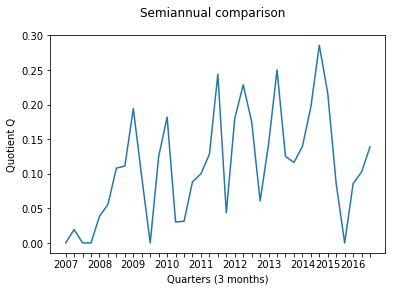

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from imports.matrix_helper import MatrixHelper
from imports.prediction_helper import PredictionHelper

matrix_helper = MatrixHelper()

quarter_between_matrices = 2
quotient_list = []
date_list = []

# get all regression file names from semiannual directory
all_files = os.listdir("data/semiannual_matrices")
file_list = [file for file in all_files if file != '.DS_Store' and file.split('_', 2)[1] == 'reg' and file.split('_', 3)[2] == 'incl']

def predict_and_validate(matrices, validation_matrices):
    # instantiate SVR Helper Class and predict values for compare matrix
    prediction_helper = PredictionHelper()
    prediction_helper.calculate_semiannual_compare_matrix(matrices, validation_matrices, penalty=0.1)

    # get the compare matrix twice:
    # Once sorted according to the PREDICTED number of vulnerabilities
    # Once sorted according to the ACTUAL number of vulnerabilities
    compare_matrix_sorted_predicted = prediction_helper.get_compare_matrix_sorted()
    compare_matrix_sorted_actual = prediction_helper.get_compare_matrix_sorted(reference_column=2)

    # Crop first 30 Samples of both matrices
    relevant_samples_count = 30
    compare_matrix_sorted_predicted = compare_matrix_sorted_predicted[range(relevant_samples_count)]
    compare_matrix_sorted_actual = compare_matrix_sorted_actual[range(relevant_samples_count)]

    # Sum up the actual number of vulnerabilities in both matrices
    f = sum(np.array(compare_matrix_sorted_predicted[:, 2], dtype='f'))
    f_opt = sum(np.array(compare_matrix_sorted_actual[:, 2], dtype='f'))

    return (f / f_opt)

def compare_files(training_file, validaiton_file):
    file_date = training_file.split('_', 3)[3].split('.', 1)[0]
    validation_date = validaiton_file.split('_', 3)[3].split('.', 1)[0]
    
    matrices = matrix_helper.load_from_parse('data/semiannual_matrices/' + training_file)
    validation_matrices = matrix_helper.load_from_parse('data/semiannual_matrices/' + validaiton_file)

    quotient = predict_and_validate(matrices, validation_matrices)
    quotient_list.append(quotient)

    if file_date.split('-', 2)[0] not in date_list:
        date_list.append(file_date.split('-', 2)[0])
    else:
        date_list.append('')

    print('* {} ({}) vs {} ({}) Koeffizient: {}'.format(file_date, matrices[0].shape[0], validation_date, validation_matrices[0].shape[0], quotient))


# loop trough pairs of matrices with the specified distance
for i in range(len(file_list) - quarter_between_matrices):
    training_file = file_list[i]
    validaiton_file = file_list[i + quarter_between_matrices]
    compare_files(training_file, validaiton_file)

# Print
print()
print('Average: {}, Max: {}'.format(sum(quotient_list) / float(len(quotient_list)), max(quotient_list)))

# Plot quotient vs. quarters
figure = plt.figure()

plt.xticks(range(len(date_list)), date_list)
plt.xlabel('Quarters (3 months)')
plt.ylabel('Quotient Q')
figure.suptitle('Semiannual comparison')
quotient, = plt.plot(range(len(date_list)), quotient_list)

figure.savefig('outputs/semiannual-incl.pdf')




### Suche nach bestem Wert

* 2007-03-22 (5564) vs 2008-03-18 (5356) Koeffizient: 0.00925925925926
* 2007-03-22 (5564) vs 2008-09-21 (6753) Koeffizient: 0.0307692307692
* 2007-03-22 (5564) vs 2009-03-21 (6995) Koeffizient: 0.00537634408602
* 2007-03-22 (5564) vs 2009-09-20 (6788) Koeffizient: 0.00884955752212
* 2007-03-22 (5564) vs 2010-03-21 (7375) Koeffizient: 0.015625
* 2007-03-22 (5564) vs 2010-09-17 (7894) Koeffizient: 0.013986013986
* 2007-03-22 (5564) vs 2011-03-17 (8170) Koeffizient: 0.0234899328859
* 2007-03-22 (5564) vs 2011-09-15 (8158) Koeffizient: 0.018018018018
* 2007-03-22 (5564) vs 2012-03-15 (9072) Koeffizient: 0.016713091922
* 2007-03-22 (5564) vs 2012-09-10 (12047) Koeffizient: 0.0153452685422
* 2007-03-22 (5564) vs 2013-03-14 (13023) Koeffizient: 0.0156599552573
* 2007-03-22 (5564) vs 2013-09-15 (14838) Koeffizient: 0.0127931769723
* 2007-03-22 (5564) vs 2014-03-17 (15160) Koeffizient: 0.0102040816327
* 2007-03-22 (5564) vs 2014-12-14 (15055) Koeffizient: 0.0134357005758
* 2007-03-22 (5564) vs

* 2011-03-17 (8170) vs 2013-09-15 (14838) Koeffizient: 0.311764705882
* 2011-03-17 (8170) vs 2014-03-17 (15160) Koeffizient: 0.340659340659
* 2011-03-17 (8170) vs 2014-12-14 (15055) Koeffizient: 0.362385321101
* 2011-03-17 (8170) vs 2015-05-30 (16171) Koeffizient: 0.326633165829
* 2011-03-17 (8170) vs 2016-03-13 (17476) Koeffizient: 0.330188679245
* 2011-03-17 (8170) vs 2016-09-12 (18654) Koeffizient: 0.334841628959
* 2011-03-17 (8170) vs 2017-03-09 (18795) Koeffizient: 0.350427350427
* 2011-09-15 (8158) vs 2012-09-10 (12047) Koeffizient: 0.298507462687
* 2011-09-15 (8158) vs 2013-03-14 (13023) Koeffizient: 0.295918367347
* 2011-09-15 (8158) vs 2013-09-15 (14838) Koeffizient: 0.280991735537
* 2011-09-15 (8158) vs 2014-03-17 (15160) Koeffizient: 0.287671232877
* 2011-09-15 (8158) vs 2014-12-14 (15055) Koeffizient: 0.234146341463
* 2011-09-15 (8158) vs 2015-05-30 (16171) Koeffizient: 0.205
* 2011-09-15 (8158) vs 2016-03-13 (17476) Koeffizient: 0.164444444444
* 2011-09-15 (8158) vs 2016-0

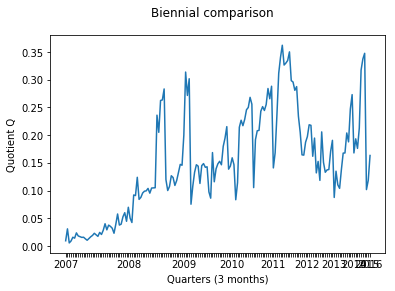

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from imports.matrix_helper import MatrixHelper
from imports.prediction_helper import PredictionHelper

matrix_helper = MatrixHelper()

quotient_list = []
date_list = []

# get all regression file names from semiannual directory
all_files = os.listdir("data/semiannual_matrices")
file_list = [file for file in all_files if file != '.DS_Store' and file.split('_', 2)[1] == 'reg' and file.split('_', 3)[2] == 'incl']

def predict_and_validate(matrices, validation_matrices):
    # instantiate SVR Helper Class and predict values for compare matrix
    prediction_helper = PredictionHelper()
    prediction_helper.calculate_semiannual_compare_matrix(matrices, validation_matrices, penalty=0.1)

    # get the compare matrix twice:
    # Once sorted according to the PREDICTED number of vulnerabilities
    # Once sorted according to the ACTUAL number of vulnerabilities
    compare_matrix_sorted_predicted = prediction_helper.get_compare_matrix_sorted()
    compare_matrix_sorted_actual = prediction_helper.get_compare_matrix_sorted(reference_column=2)

    # Crop first 30 Samples of both matrices
    relevant_samples_count = 30
    compare_matrix_sorted_predicted = compare_matrix_sorted_predicted[range(relevant_samples_count)]
    compare_matrix_sorted_actual = compare_matrix_sorted_actual[range(relevant_samples_count)]

    # Sum up the actual number of vulnerabilities in both matrices
    f = sum(np.array(compare_matrix_sorted_predicted[:, 2], dtype='f'))
    f_opt = sum(np.array(compare_matrix_sorted_actual[:, 2], dtype='f'))

    return (f / f_opt)

def compare_files(training_file, validaiton_file):
    file_date = training_file.split('_', 3)[3].split('.', 1)[0]
    validation_date = validaiton_file.split('_', 3)[3].split('.', 1)[0]
    
    matrices = matrix_helper.load_from_parse('data/semiannual_matrices/' + training_file)
    validation_matrices = matrix_helper.load_from_parse('data/semiannual_matrices/' + validaiton_file)

    # get number of vulnerable samples to check if there are any vulnerable samples before try
    vulnerable_samples_count = len([i for i in matrices[0] if i[-1] > 0])
    vulnerable_validation_samples_count = len([i for i in validation_matrices[0] if i[-1] > 0])
    
    if vulnerable_samples_count >= 0 and vulnerable_validation_samples_count >= 0:
        quotient = predict_and_validate(matrices, validation_matrices)
        quotient_list.append(quotient)
        
        if file_date.split('-', 2)[0] not in date_list:
            date_list.append(file_date.split('-', 2)[0])
        else:
            date_list.append('')

        print('* {} ({}) vs {} ({}) Koeffizient: {}'.format(file_date, matrices[0].shape[0], validation_date, validation_matrices[0].shape[0], quotient))


# loop trough pairs of matrices with the specified distances
min_quarter_between_matrices = 4
quarter_between_predictions = 2
a = 0
b = min_quarter_between_matrices

while(a < len(file_list) - min_quarter_between_matrices):
    b = a + min_quarter_between_matrices
    while(b < len(file_list)):
        training_file = file_list[a]
        validaiton_file = file_list[b]
        compare_files(training_file, validaiton_file)
        
        b += quarter_between_predictions
    a += quarter_between_predictions

# Print
print()
print('Average: {}, Max: {}'.format(sum(quotient_list) / float(len(quotient_list)), max(quotient_list)))

# Plot quotient vs. quarters
figure = plt.figure()

plt.xticks(range(len(date_list)), date_list)
plt.xlabel('Quarters (3 months)')
plt.ylabel('Quotient Q')
figure.suptitle('Biennial comparison')
quotient, = plt.plot(range(len(date_list)), quotient_list)

figure.savefig('outputs/nonesense.pdf')
